# Fast Fourier Transform (FFT)

## Objectives

* Learn a bit about the way a FFT works
* Cover two methods to implement the Cooly-Tukey FFT
* Mention compression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

### The Fast Fourier Transform

The FFT has been called one of the 10 most important algorithms of our time. Let's take a second to look at the pair of lists [available here](https://nickhigham.wordpress.com/2016/03/29/the-top-10-algorithms-in-applied-mathematics/):

| 2016 PCAM index | 2000 Computing in Science and Engineering |
|----------------------------------------|------------------------|
| Newton and quasi-Newton methods        | The Fortran Optimizing Compiler |
| Matrix factorizations (LU, Cholesky, QR) | --- |
| Singular value decomposition, QR and QZ algorithms| --- |
| Monte-Carlo methods                    | --- |
| Fast Fourier transform                 | --- |
| Krylov subspace methods (conjugate gradients, Lanczos, GMRES, minres) | --- |
| JPEG                                   | Quicksort algorithm for sorting |
| PageRank                               | Integer relation detection |
| Simplex algorithm                      | --- |
| Kalman filter                          | Fast multipole method |

(The items that match are marked with ---). Both lists prominently feature the FFT.

Why is FFT so important? Let's look at performance. A way to relate different algorithms is the order, $\mathcal{O}$. This gives you an idea of how the algorithm grows with the size of the problem - it says nothing about the overall time. Hopefully, overall speed is optimal for an algorithm; maybe we are using Numba or something like that; but even if you are not, the order still holds between similar implementations. The order really describes the number of operations an algorithm requires, but that should be related to the time. It was invented by Gauss in in 1805 but revived and implemented by Cooley+Tukey in 1965.

Assuming you have N elements,

* $\mathcal{O}(1)$: Does not depend on the number of elements at all, just takes a constant amount of time.
* $\mathcal{O}(N)$: Doubling the number of elements doubles the about of time
* $\mathcal{O}(N^2)$: Doubling the number of elements quadruples the about of time

Etc.

If you look at the Discrete Fourier Transform (DFT) algorithm, you'll see it has $N\times N$ calculations, so it is order $\mathcal{O}(N^2)$. This means for $N=1,000$ elements, you would need $1,000,000$ calculations (where "calculations" has an unspecified size). FFTs are order $\mathcal{O}(N \log_2 N)$ instead. So, since $1024 = 2^{10}$, this is roughly $1000\times 10 = 10,000$ calculations - that's 100 times faster. Feel free to repeat the calculation with $1,000,000$ elements, which is not unreasonable for an FT problem.

Even more, let us take an extreme, let say $N \sim 10^9$, therefore, $N^2 \sim 10^{18}$. Instead, FFT will be $N \log_2 N ~ 30x10^9$, and let us say that each operation takes 1 ns. Then, For the simple DFT, we will have $10^{18} \sim 31.2 years$, while FFT will be $30x10^{9} \sim 30 sec$.

Let's revisit the DFT algorithm:

$$
Z_N = e^{-2 \pi i / N} \\
Y_n = \frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N-1} Z_N^{n k} y_k
$$

Here we have adjusted the formula from last time slightly to ensure both $n$ and $k$ start at 0. (The book seems to have an error here, because in later discussions the k's start from 0.)
Since both $n$ and $k$ vary over $N$ values, this is $N^2$ calculations ($N$ complex multiplcations and $N-1$ additions). Let's investigate the most popular FFT algorithm, the Cooley–Tukey FFT. This one requires you have a power of 2 number of elements. Other FFT algorithms exist - but you can always "pad" your data to the next power of two and use this one.

### Cooly-Tukey FFT

Our approach is a bit different in the book, feel free to look at that too. The idea here is to use that maybe there is a connection between the real and imaginary part of the components. It will exploit symmetries of $Z_N^{k}$:

**Complex conjugate symmetry**
$$
Z_N^{k(N-n)} = Z_N^{-kn} = (Z_N^{kn})^*
$$

**Periodicity**
$$
Z_N^{kn} = Z_N^{k(N+n)} = Z_N^{(k+N)n}
$$

We can break the DFT calculation into two pieces, the even $k$ terms and the odd $k$:

$$
Y_n =
\frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N/2 - 1} Z_N^{n (2 k)} y_{2 k} +
\frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N/2 - 1} Z_N^{n (2 k + 1)} y_{2 k + 1}
$$

We can then make two definitions here:

$$
E_n \equiv  \frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N/2 - 1} Z_N^{n (2 k)} y_{2 k} \\
O_n \equiv  \frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N/2 - 1} Z_N^{n (2 k)} y_{2 k + 1}
$$

So the above expression becomes (sum over two FT but over N/2 points):

$$
Y_n = E_n + Z_N^n O_n
$$

Given that this is periodic, we can also compute $Y_{n+N/2}$:

$$
Y_{n+N/2} =
\frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N/2 - 1} Z_N^{(n+N/2) (2 k)} y_{2 k} +
\frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N/2 - 1} Z_N^{(n+N/2) (2 k + 1)} y_{2 k + 1}
$$

We can expand the terms in the exponents:

$$
Y_{n+N/2}=
 \frac{1}{\sqrt{2\pi}}\sum_{k=0}^{N/2-1}Z_N^{2kn}Z_N^{Nk}y_{2k}
+Z^{n}Z^{N/2}\frac{1}{\sqrt{2\pi}}\sum_{k=0}^{N/2-1}Z_N^{2kn}Z_N^{kN}y_{2k+1}
$$

However, by using our definition of $Z_N$, we have $Z_N^{kN} = e^{-2 \pi i k}$. For integer $k$, this is just 1. We can also evaluate $Z_N^{N/2} = e^{- \pi i} = -1$. At this point, we have now recovered the original expression, with a relative minus sign!

$$
Y_{n+N/2}   =
 \frac{1}{\sqrt{2\pi}}\sum_{k=0}^{N/2-1}Z_N^{2kn}y_{2k}
-Z_N^{n}\frac{1}{\sqrt{2\pi}}\sum_{k=0}^{N/2-1}Z_N^{2kn}y_{2k+1}
$$

where $Z_N^2 = e^{- 2 2 \pi i / N} = e^{- 2 \pi i / (N/2)} = Z_{N/2}^2$
$$
Y_{n+N/2} = E_n - Z_{N}^n O_n
$$

Here now, So now we can split our sum into two pieces, odd and even, then combine using the above definitions to produce 2 outputs for each calculation. We could continue to break up the sum in this manor, until we have 1 item in each - this is a recursive algorithm, and it's where the $\log_2(N)$ comes from. And, one item is really simple to calculate, that's just $E_0 = y_0$ and $O_0 = y_1$ (dropping the $1/\sqrt{2 \pi}$ factor, since you can add that later).

Let see how it works:

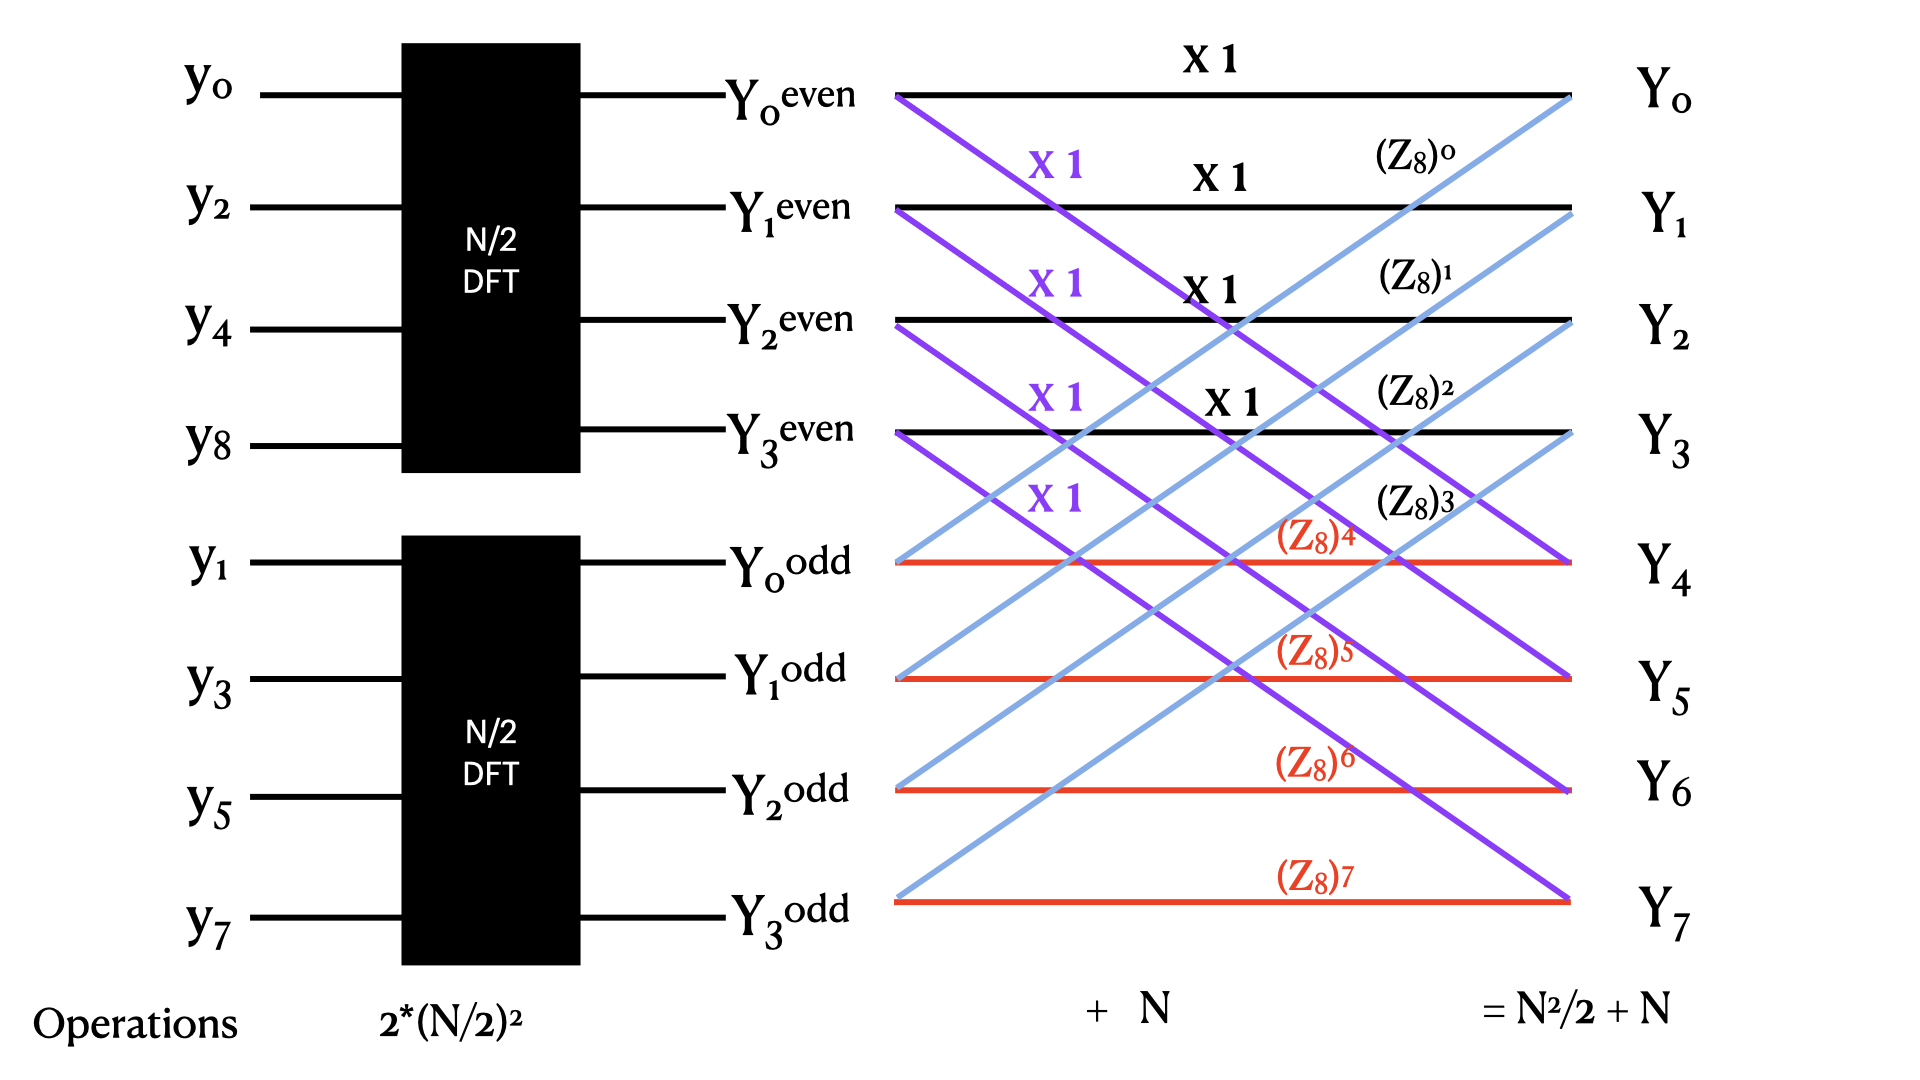

If we continue splitting the data. Each $N/2$ is now split again into two $N/4$ DFT. How many times can I do this? $N/2, N/2^2, N/2^3,\cdots,N/2^m = 1$, where $m = \log_2 N$. Therefore, the number of operations would be

If $N/2$ then $2 (N/2)^2 + N = N^2/2+N$

If $N/4$ then $2 ( 2 (N/4)^2 + N/2) + N = N^2/4 + 2N$

If $N/8$ then $2 ( 2 (2 (N/8)^2 + N/4) + N/2) + N = N^3/8 + 3N

if $N/2^m$ would be $N^2/2^m +  mN \sim N \log_2 N $ if N is large.

IN the case of $N = 8$, the $2^3 = 8$. Therefore $ m = 3$. The previous diagram is repeated then three times.

### Recursive Cooly-Tukey FFT

Let's try it:

In [2]:
# @numba.njit
def ct_fft_recursive(x):
    N = len(x)

    if N == 1:
        return x

    Z = np.exp(-2 * np.pi * 1j / N)
    k = np.arange(N // 2)

    # remember that x[::2] means going over the vector in steps of 2
    # x = array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    # x[::2] = array([0, 2, 4, 6, 8])
    evens = ct_fft_recursive(x[::2])
    odds = Z ** k * ct_fft_recursive(x[1::2])

    return np.concatenate((evens + odds, evens - odds))

In [3]:
N = 2 ** 9
T = 1.0 / 800.0
x = np.linspace(0.0, N * T, N)
y = np.sin(50.0 * 2.0 * np.pi * x) + 0.5 * np.sin(80.0 * 2.0 * np.pi * x)

In [4]:
# If you want to JIT the above function, either use `return x + 0j` or the following:
y = y.astype(complex)

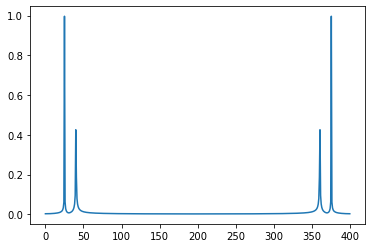

In [5]:
# Our algorithm
yf = ct_fft_recursive(y)
xf = np.linspace(0.0, 1.0 / (2.0 * T), N)
norm_yf = 2.0 / N * np.abs(yf)

plt.plot(xf, norm_yf)
plt.show()

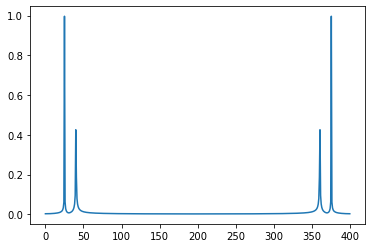

In [6]:
# Official Numpy algorithm
yf = np.fft.fft(y)
xf = np.linspace(0.0, 1.0 / (2.0 * T), N)
norm_yf = 2.0 / N * np.abs(yf)

plt.plot(xf, norm_yf)
plt.show()

In [7]:
%%timeit
ct_fft_recursive(y)

4.6 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%%timeit
np.fft.fft(y)

9.21 µs ± 217 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


You can get a factor 10 speed up from Numba; further gains could be obtained by avoiding the memory allocations and things like that. There are also other

### Bitflip Cooly-Tukey FFT

Like many recursive algorithms, you can also implement this in a normal loop, as well. We just need to get the ordering right - the algorithm above has a special output order: it is the same as flipping the bits on an N length binary number.


This algorithm can be best seen by looking at a feature of the above multiplication, $nk$. Let's look at a matrix of $nk$:

In [9]:
N = 8
n_or_k = np.arange(N)
print(n_or_k)
nk = n_or_k.reshape(1, -1) * n_or_k.reshape(-1, 1)
for row in nk:
    # printing with > means The field will be right-aligned within the available space
    print(" + ".join(f"{v: >2}" for v in row))

[0 1 2 3 4 5 6 7]
 0 +  0 +  0 +  0 +  0 +  0 +  0 +  0
 0 +  1 +  2 +  3 +  4 +  5 +  6 +  7
 0 +  2 +  4 +  6 +  8 + 10 + 12 + 14
 0 +  3 +  6 +  9 + 12 + 15 + 18 + 21
 0 +  4 +  8 + 12 + 16 + 20 + 24 + 28
 0 +  5 + 10 + 15 + 20 + 25 + 30 + 35
 0 +  6 + 12 + 18 + 24 + 30 + 36 + 42
 0 +  7 + 14 + 21 + 28 + 35 + 42 + 49


Notice there are lots of repeats here - this means we are doing the same calculation many times. Let's keep going. Since Z has some special properties; it is $e^{−2 \pi i/N}$, so we can use the properties that $Z^{(n-N/2)} = -Z^{n}$ and $Z^{(n-N)} = Z^{n}$ to rewrite all indices in terms of the first $N/2$ indices.

In [10]:
for row in nk:
    print(", ".join(f"{'+' if v%8 < 4 else '-'}{v%4}" for v in row))

+0, +0, +0, +0, +0, +0, +0, +0
+0, +1, +2, +3, -0, -1, -2, -3
+0, +2, -0, -2, +0, +2, -0, -2
+0, +3, -2, +1, -0, -3, +2, -1
+0, -0, +0, -0, +0, -0, +0, -0
+0, -1, +2, -3, -0, +1, -2, +3
+0, -2, -0, +2, +0, -2, -0, +2
+0, -3, -2, -1, -0, +3, +2, +1


We can now group alternating columns:

In [11]:
# Check columns (0,4), (1,5)
for row in nk:
    print(
        ", ".join(
            f"{'+' if v1%8 < 4 else '-'} "
            f"{'+' if v2%8 < 4 else '-'} "
            f"{v1%4} {v1%4}"
            for v1, v2 in zip(row[:4], row[4:])
        )
    )

+ + 0 0, + + 0 0, + + 0 0, + + 0 0
+ - 0 0, + - 1 1, + - 2 2, + - 3 3
+ + 0 0, + + 2 2, - - 0 0, - - 2 2
+ - 0 0, + - 3 3, - + 2 2, + - 1 1
+ + 0 0, - - 0 0, + + 0 0, - - 0 0
+ - 0 0, - + 1 1, + - 2 2, - + 3 3
+ + 0 0, - - 2 2, - - 0 0, + + 2 2
+ - 0 0, - + 3 3, - + 2 2, - + 1 1


If we pull the sign out, we get:

In [12]:
for row in nk:
    print(
        " ".join(
            f"{'+' if v1%8 < 4 else '-'} Z^{v1%4} "
            f"(y_{n} "
            f"{'+' if (v2%8 < 4) ^ (v1%8 >= 4) else '-'} "
            f"y_{n+4})"
            for n, v1, v2 in zip(range(4), row[:4], row[4:])
        )
    )

+ Z^0 (y_0 + y_4) + Z^0 (y_1 + y_5) + Z^0 (y_2 + y_6) + Z^0 (y_3 + y_7)
+ Z^0 (y_0 - y_4) + Z^1 (y_1 - y_5) + Z^2 (y_2 - y_6) + Z^3 (y_3 - y_7)
+ Z^0 (y_0 + y_4) + Z^2 (y_1 + y_5) - Z^0 (y_2 + y_6) - Z^2 (y_3 + y_7)
+ Z^0 (y_0 - y_4) + Z^3 (y_1 - y_5) - Z^2 (y_2 - y_6) + Z^1 (y_3 - y_7)
+ Z^0 (y_0 + y_4) - Z^0 (y_1 + y_5) + Z^0 (y_2 + y_6) - Z^0 (y_3 + y_7)
+ Z^0 (y_0 - y_4) - Z^1 (y_1 - y_5) + Z^2 (y_2 - y_6) - Z^3 (y_3 - y_7)
+ Z^0 (y_0 + y_4) - Z^2 (y_1 + y_5) - Z^0 (y_2 + y_6) + Z^2 (y_3 + y_7)
+ Z^0 (y_0 - y_4) - Z^3 (y_1 - y_5) - Z^2 (y_2 - y_6) - Z^1 (y_3 - y_7)


Notice the pattern here. The recursive nature of the pattern is what provided the previous method to work. Now let's instead expand this in loops.

Note that $y_0$ needs $y_4$ close, therefore, $y_4$ should be in position 1. Therefore a nice order should be $y_0, y_4, y_2, y_6, y_1, y_5, y_3, y_7$. Why?

Because, if we have $y_0, y_1, y_2, y_3, y_4, y_5, y_6, y_7$, each number in binary would be $(000), (001), (010), (011),(100), (101), (110), (111)$. If we reverse the order, we get $(000), (100), (010), (110),(001), (101), (011), (111)$, which are $y_0, y_4, y_2, y_5, y_3, y_7$. Therefore, expressing the label of the entry in binary will provide the order in the vector that will make the calculations faster.

First let's define a bitflip operation that reversed the order of bits; this reverses a butterfly join like the one above.

In [13]:
# basically the number will give the order in the list for example
# 1 = 0 0 1
# everting 1 0 0 , which is 7

def bitflip(i, L):
    length = int(L)  # Expected number of bits
    str_number = f"{i:0{length}b}"  # Convert to string of 0's and 1's, correct length
    return int(str_number[::-1], 2)  # Reverse and convert to int (base 2)

In [14]:
for i in range(8):
    print(i,bitflip(i, np.log2(8)))  # 110 becomes 011

0 0
1 4
2 2
3 6
4 1
5 5
6 3
7 7


If converting to strings bother you, we can use bit shifts instead. Let's make this a numba function so we can make the loop function numba too if we want to.

In [15]:
# Check here for bitwise operations https://wiki.python.org/moin/BitwiseOperators
@numba.njit
def bitflip(i, L):
    L = int(L)
    result = 0
    for _ in range(int(L)):
        result |= i & 1
        i >>= 1
    return result

In [16]:
for i in range(8):
    print(bitflip(i, np.log2(8)))  # 110 becomes 011

0
1
1
1
1
1
1
1


Now, we are going to need to produce three values; `p`, `first`, and `second`. This is easiest to see, I believe, if you look at figure 12.10 in the book. Let's make sure we loop properly here:

In [17]:
N = 8
times = int(np.log2(N))

for k in range(times):
    for j in range(N // 2):
        wid = 2 ** (times - k - 1)
        p = bitflip((j // wid), times - 1)
        first = (j // wid) * wid + j
        second = (j // wid) * wid + j + wid
        print(
            p, first, second,
        )
    print()

0 0 4
0 1 5
0 2 6
0 3 7

0 0 2
0 1 3
1 4 6
1 5 7

0 0 1
1 2 3
1 4 5
1 6 7



Let's put this together into our loop:

In [18]:
# @numba.njit
def ct_fft_loop(x, Z=None):
    x = x.copy()  # just to make sure we don't mess up the input
    y = x.copy()

    N = len(x)  # Number of data points
    times = int(np.log2(N))  # Number of times (the log_2 N part)

    if Z is None:  # We can support sympy too
        Z = np.exp(-2 * np.pi * 1j / N)  # with this addition.

    for k in range(times):
        wid = 2 ** (times - k - 1)
        x, y = y, x  # Trade pointers (0 copy)
        for j in range(N // 2):
            p = bitflip((j // wid), times - 1)  # The power on z
            first = (j // wid) * wid + j  # First index
            second = (j // wid) * wid + j + wid  # Second index

            left = x[first]  # Precompute terms
            right = Z ** p * x[second]

            y[first] = left + right
            y[second] = left - right

    for i in range(N):
        x[i] = y[bitflip(i, times)]

    return x

Let's just verify that this works. We'll drop Sympy variables into our algorithm and see if we get the right terms:

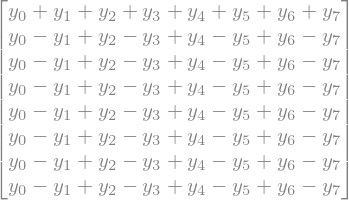

In [19]:
# Our algorithm
from sympy import symbols, init_printing, Matrix

init_printing()
ys = Matrix(symbols("y:8"))
Z = symbols("Z")
yf = ct_fft_loop(ys, Z)
yf

In [20]:
init_printing(pretty_print=False)

Now, let's set our example back up and test it out:

In [21]:
N = 2 ** 9
T = 1.0 / 800.0
x = np.linspace(0.0, N * T, N)
y = np.sin(50.0 * 2.0 * np.pi * x) + 0.5 * np.sin(80.0 * 2.0 * np.pi * x)

In [22]:
# If you want to JIT the above function, either use `return x + 0j` or the following:
y = y.astype(complex)

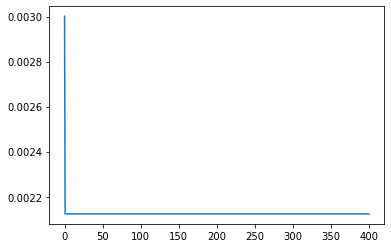

In [23]:
# Our algorithm
yf = ct_fft_loop(y)
xf = np.linspace(0.0, 1.0 / (2.0 * T), N)
norm_yf = 2.0 / N * np.abs(yf)

plt.plot(xf, norm_yf)
plt.show()

We are significanly nicer on memory, as well as avoiding lots of function calls, so we get a bit better on time. We are still not close to the official codes, however, even with numba. So, don't write your own ffts!

In [24]:
%%timeit
ct_fft_loop(y)

3.41 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%%timeit
np.fft.fft(y)

9.18 µs ± 356 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## FFTs for compression

How could an FFT be used for compression? If we truncate the series, we can throw away the high frequency components of a signal, while keeping the basic (low frequency) shape intact. Let's try:

In [26]:
x = np.linspace(-50, 50, 1000)
y = np.sin(x) / x

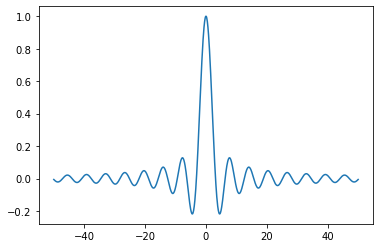

In [27]:
plt.plot(x, y)

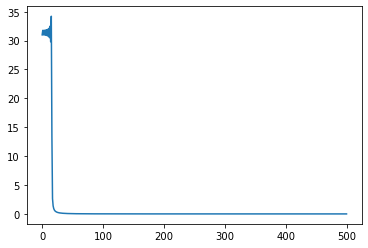

In [28]:
ft = np.fft.rfft(y)
plt.plot(np.abs(ft))

#### Lossy compression:

In [29]:
ft[30:] = 0

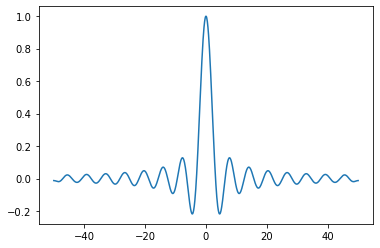

In [30]:
yp = np.fft.irfft(ft)
plt.plot(x, yp)

## Another example  - Image and Smoothing

Start with data that have a whole range of frequencies

We then FT and discard some frequencies, high frequencies  (low pass) or low frequencies (high pass) or discard those frequencies which have small coefficients (Fourier smoothing)

Use the Inverse FT to obtain the data back

In [63]:
# Low pass filter
x=np.linspace(0,1,100)
dt=x[1]-x[0]
# two frequencies, 1Hz and 5 Hz

# observe that here we are just sampling the data
y=np.sin(2*np.pi*x)+0.2*np.cos(10*np.pi*x)

[ 0.02        5.90070743  0.02943358 -3.69509449  0.03352272 -0.86828075
  0.0436407  -0.4039585   0.07568405 -0.23558794]


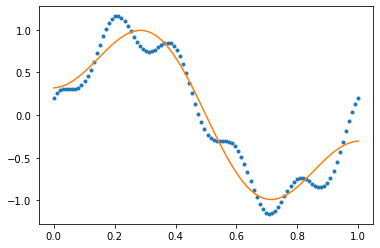

In [64]:
from scipy.fftpack import fft, ifft, dct, idct

# dct will give real values. Discrete Cosine Transform  with normalization
dct = dct(y, norm="ortho")
print(dct[:10])
dct[4:]=0
smoothed=idct(dct, norm="ortho")

plt.plot(x,y,".")
plt.plot(x,smoothed)

#High frequency components are gone!

In [59]:
# Now let us some noise to the data

y_noise = y + 1.5*np.random.randn(len(x))

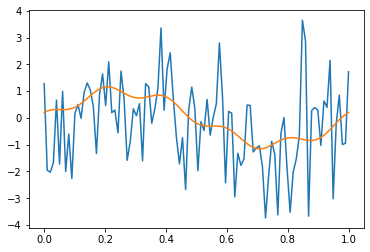

In [61]:
plt.plot(x,y_noise)
plt.plot(x,y)

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/anaconda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


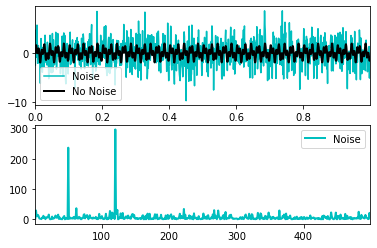

In [68]:
dt = 0.001
x=np.arange(0,1,dt)
y=np.sin(2*np.pi*50*x)+np.sin(2*np.pi*120*x)
y_noise = y + 2.5*np.random.randn(len(x))
n=len(x)

#fhat are the Fourier coefficients
fhat=np.fft.fft(y_noise,n)

# Find the power spectrum in units of Hz^2
PSD = fhat * np.conj(fhat)/n
freq=(1/(dt*n))*np.arange(n)
L = np.arange(1,np.floor(n/2),dtype='int')  # plot only the first half

fig,axs = plt.subplots(2,1)

plt.sca(axs[0])
plt.plot(x,y_noise,color='c',LineWidth=1.5,label='Noise')
plt.plot(x,y,color='k',LineWidth=2,label='No Noise')
plt.xlim(x[0],x[-1])
plt.legend()

plt.sca(axs[1])
plt.plot(freq[L], PSD[L],color='c',LineWidth=2,label='Noise')
plt.xlim(freq[L[0]],freq[L[-1]])
plt.legend()

plt.show()

Look at the spectra, two huge pieack at 50 and 120 Hz!. Therefore we can clean the signal (filter), any Fourier coefficient that is smaller than 100.0 we will put it to zero.

/usr/local/anaconda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


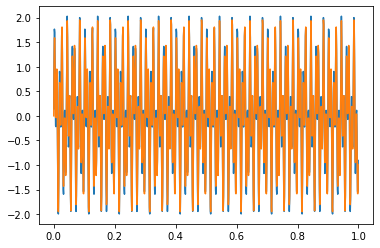

In [71]:
# select indices greater than 100 -> 1
indices = PSD > 100

PSDfiltered = PSD * indices

fhat = indices * fhat

ffit = np.fft.ifft(fhat)

plt.plot(x,ffit)
plt.plot(x,y)

## Another example  - Image Filtering

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt,exp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


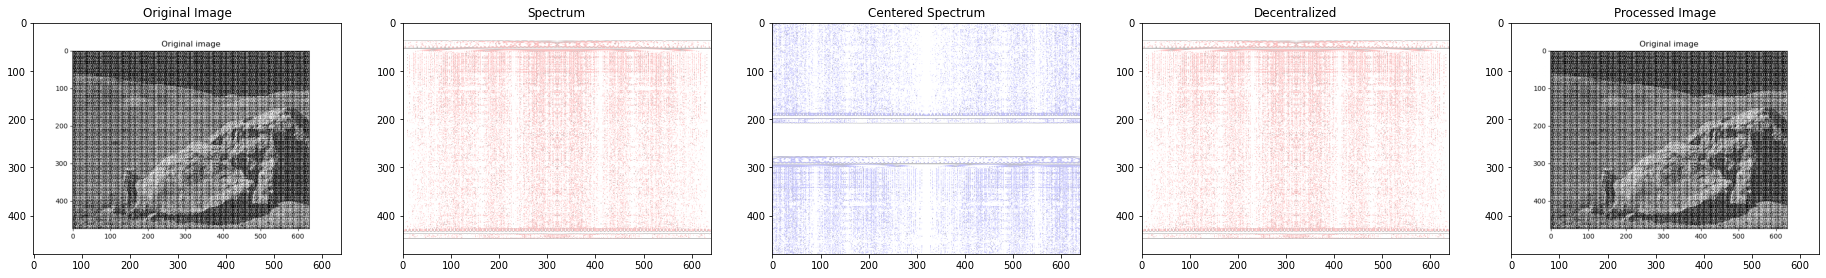

In [44]:

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

img = cv2.imread("img/moonlanding.png", 0)

plt.subplot(151), plt.imshow(img, "gray"), plt.title("Original Image")

original = np.fft.fft2(im)
plt.subplot(152), plt.imshow(np.log(1+np.abs(original)), "gray"), plt.title("Spectrum")

center = np.fft.fftshift(original)
plt.subplot(153), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Centered Spectrum")

inv_center = np.fft.ifftshift(center)
plt.subplot(154), plt.imshow(np.log(1+np.abs(inv_center)), "gray"), plt.title("Decentralized")

processed_img = np.fft.ifft2(inv_center)
plt.subplot(155), plt.imshow(np.abs(processed_img), "gray"), plt.title("Processed Image")

plt.show()

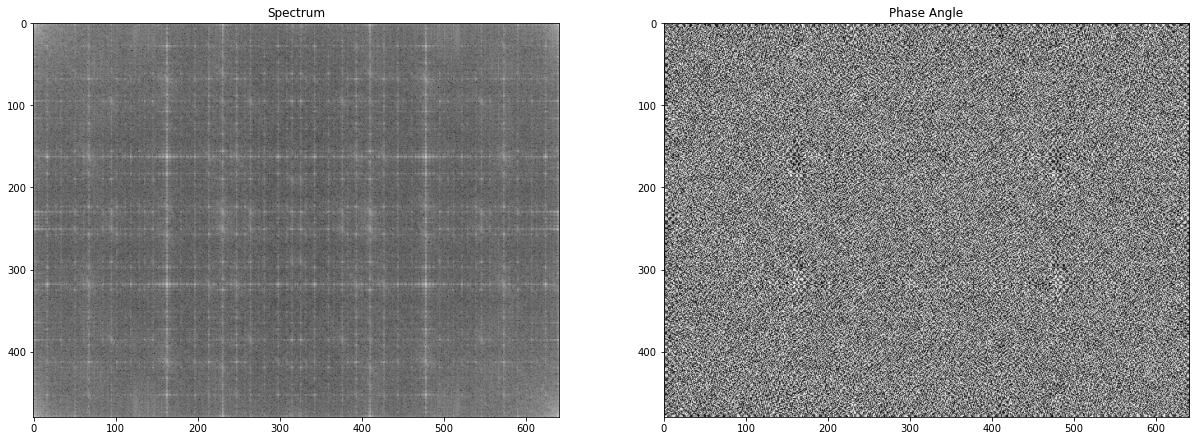

In [46]:
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

img = cv2.imread("img/moonlanding.png", 0)

original = np.fft.fft2(img)
plt.subplot(131), plt.imshow(np.log(np.abs(original)), "gray"), plt.title("Spectrum")

plt.subplot(132), plt.imshow(np.angle(original), "gray"), plt.title("Phase Angle")
plt.show()

In [47]:
def distance(point1,point2):
    return sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def idealFilterLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 1
    return base

def idealFilterHP(D0,imgShape):
    base = np.ones(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 0
    return base

def butterworthLP(D0,imgShape,n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1/(1+(distance((y,x),center)/D0)**(2*n))
    return base

def butterworthHP(D0,imgShape,n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1-1/(1+(distance((y,x),center)/D0)**(2*n))
    return base

def gaussianLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

def gaussianHP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1 - exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

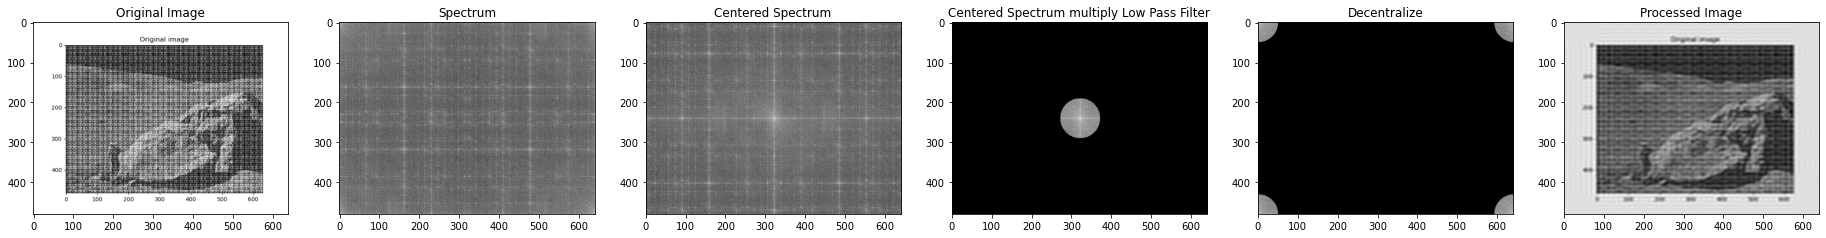

In [48]:
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

img = cv2.imread("img/moonlanding.png", 0)
plt.subplot(161), plt.imshow(img, "gray"), plt.title("Original Image")

original = np.fft.fft2(img)
plt.subplot(162), plt.imshow(np.log(1+np.abs(original)), "gray"), plt.title("Spectrum")

center = np.fft.fftshift(original)
plt.subplot(163), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Centered Spectrum")

LowPassCenter = center * idealFilterLP(50,img.shape)
plt.subplot(164), plt.imshow(np.log(1+np.abs(LowPassCenter)), "gray"), plt.title("Centered Spectrum multiply Low Pass Filter")

LowPass = np.fft.ifftshift(LowPassCenter)
plt.subplot(165), plt.imshow(np.log(1+np.abs(LowPass)), "gray"), plt.title("Decentralize")

inverse_LowPass = np.fft.ifft2(LowPass)
plt.subplot(166), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Processed Image")

plt.show()

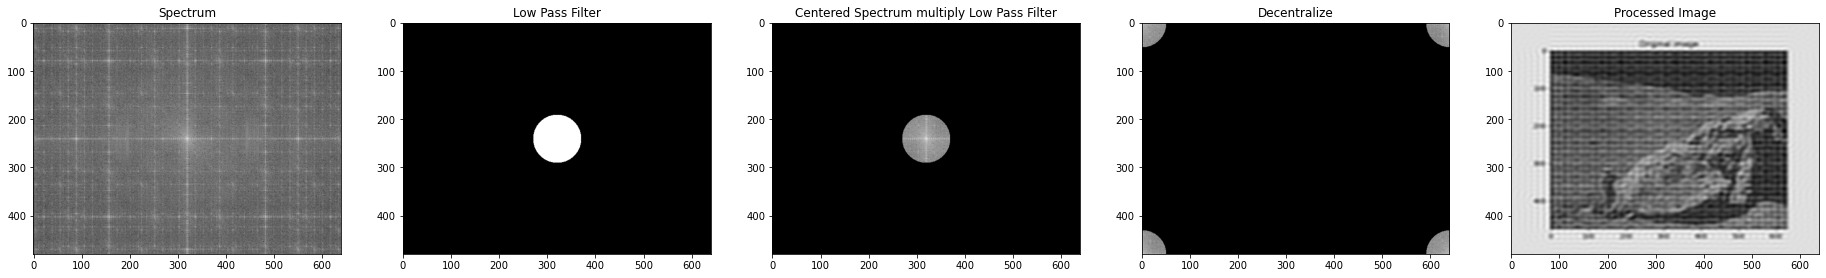

In [49]:
img = cv2.imread("img/moonlanding.png", 0)
original = np.fft.fft2(img)
center = np.fft.fftshift(original)

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

plt.subplot(151), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Spectrum")

LowPass = idealFilterLP(50,img.shape)
plt.subplot(152), plt.imshow(np.abs(LowPass), "gray"), plt.title("Low Pass Filter")

LowPassCenter = center * idealFilterLP(50,img.shape)
plt.subplot(153), plt.imshow(np.log(1+np.abs(LowPassCenter)), "gray"), plt.title("Centered Spectrum multiply Low Pass Filter")

LowPass = np.fft.ifftshift(LowPassCenter)
plt.subplot(154), plt.imshow(np.log(1+np.abs(LowPass)), "gray"), plt.title("Decentralize")

inverse_LowPass = np.fft.ifft2(LowPass)
plt.subplot(155), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Processed Image")

plt.show()

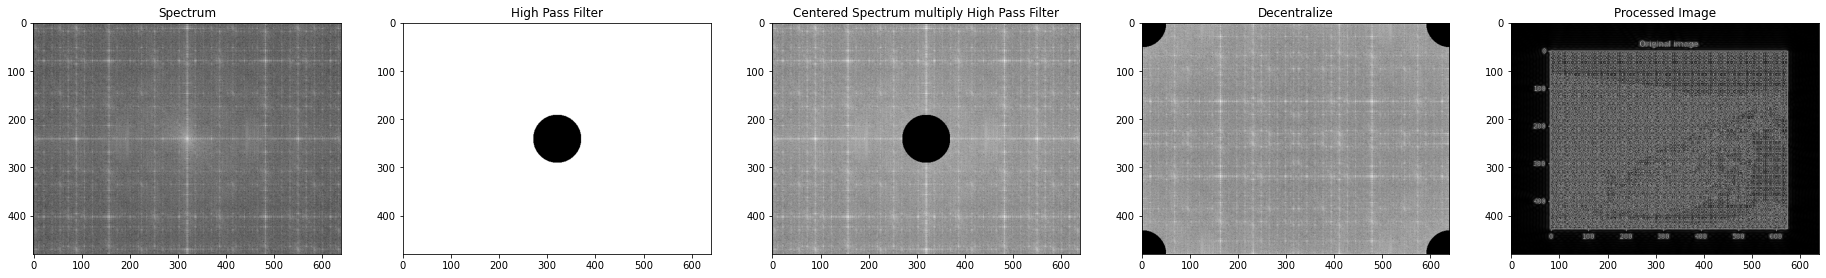

In [50]:
img = cv2.imread("img/moonlanding.png", 0)
original = np.fft.fft2(img)
center = np.fft.fftshift(original)

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

plt.subplot(151), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Spectrum")

HighPass = idealFilterHP(50,img.shape)
plt.subplot(152), plt.imshow(np.abs(HighPass), "gray"), plt.title("High Pass Filter")

HighPassCenter = center * idealFilterHP(50,img.shape)
plt.subplot(153), plt.imshow(np.log(1+np.abs(HighPassCenter)), "gray"), plt.title("Centered Spectrum multiply High Pass Filter")

HighPass = np.fft.ifftshift(HighPassCenter)
plt.subplot(154), plt.imshow(np.log(1+np.abs(HighPass)), "gray"), plt.title("Decentralize")

inverse_HighPass = np.fft.ifft2(HighPass)
plt.subplot(155), plt.imshow(np.abs(inverse_HighPass), "gray"), plt.title("Processed Image")

plt.show()

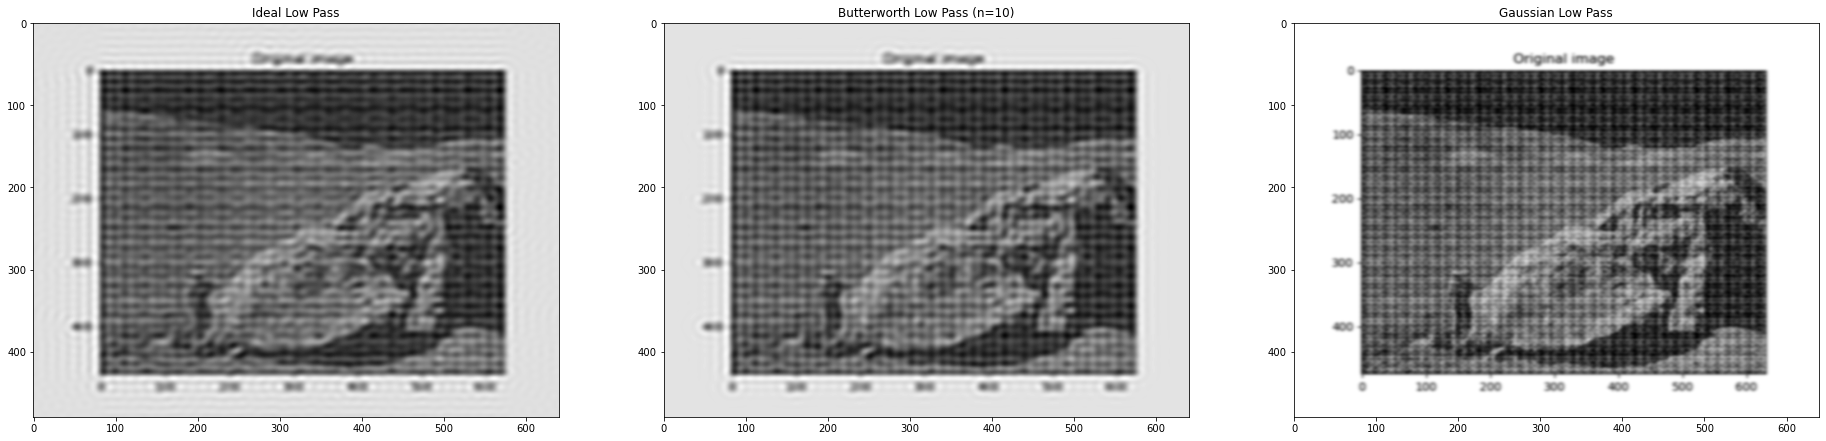

In [51]:
img = cv2.imread("img/moonlanding.png", 0)
original = np.fft.fft2(img)
center = np.fft.fftshift(original)

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

LowPassCenter = center * idealFilterLP(50,img.shape)
LowPass = np.fft.ifftshift(LowPassCenter)
inverse_LowPass = np.fft.ifft2(LowPass)
plt.subplot(131), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Ideal Low Pass")

LowPassCenter = center * butterworthLP(50,img.shape,10)
LowPass = np.fft.ifftshift(LowPassCenter)
inverse_LowPass = np.fft.ifft2(LowPass)
plt.subplot(132), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Butterworth Low Pass (n=10)")

LowPassCenter = center * gaussianLP(50,img.shape)
LowPass = np.fft.ifftshift(LowPassCenter)
inverse_LowPass = np.fft.ifft2(LowPass)
plt.subplot(133), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Gaussian Low Pass")

plt.show()

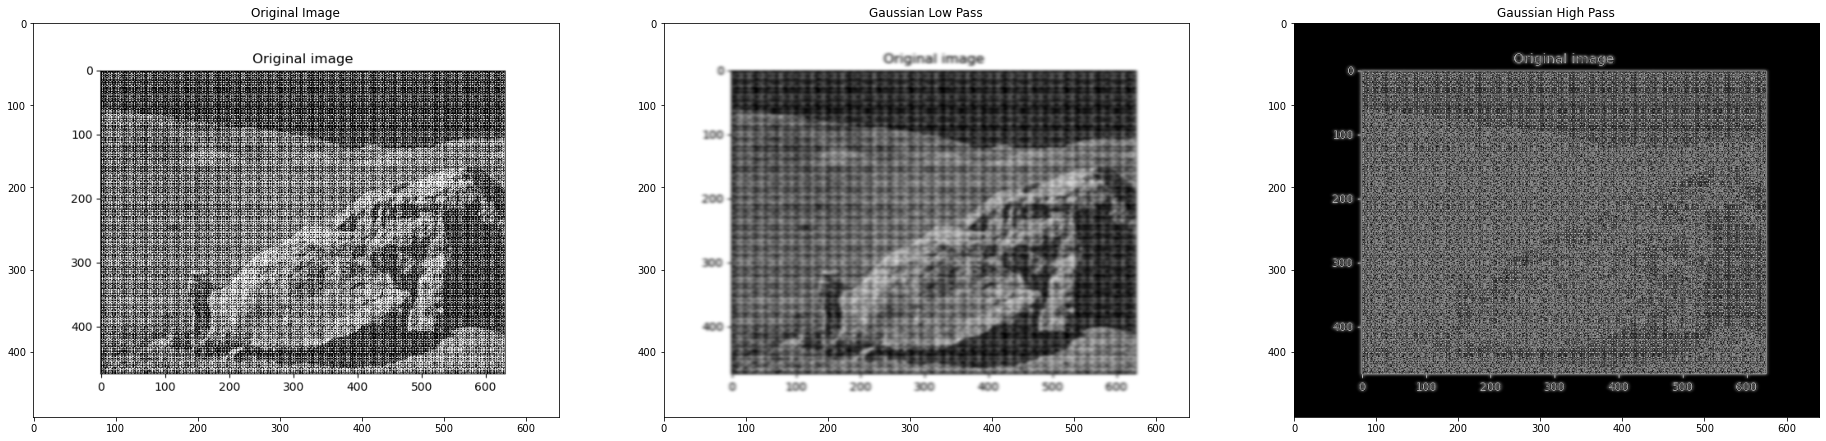

In [52]:
img = cv2.imread("img/moonlanding.png", 0)
original = np.fft.fft2(img)
center = np.fft.fftshift(original)

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

plt.subplot(131), plt.imshow(img, "gray"), plt.title("Original Image")

LowPassCenter = center * gaussianLP(50,img.shape)
LowPass = np.fft.ifftshift(LowPassCenter)
inverse_LowPass = np.fft.ifft2(LowPass)
plt.subplot(132), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Gaussian Low Pass")

HighPassCenter = center * gaussianHP(50,img.shape)
HighPass = np.fft.ifftshift(HighPassCenter)
inverse_HighPass = np.fft.ifft2(HighPass)
plt.subplot(133), plt.imshow(np.abs(inverse_HighPass), "gray"), plt.title("Gaussian High Pass")

plt.show()